# Portfolio Theory Analysis

This notebook explores various aspects of portfolio theory using real financial data. The workflow includes:

- Importing and processing stock price data from text and TSV files.
- Calculating returns, mean vectors, and covariance matrices for a set of stocks.
- Implementing and testing portfolio optimization functions, including constraints on weights.
- Plotting the efficient frontier using both empirical and model-based covariance matrices.
- Performing regression analysis to estimate factor model parameters (betas, alphas, idiosyncratic risk).
- Comparing empirical and estimated covariance matrices and their impact on portfolio optimization.
- Visualizing regression fits and residuals for individual stocks.

The notebook demonstrates practical applications of quantitative finance concepts such as mean-variance optimization, factor models, and regression analysis, providing both code and visualizations to support the analysis.

In [131]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from cvxopt import matrix, solvers
import yfinance as yf
import os 
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Question 1

In [132]:
path = r"C:\Users\bjorn\FE630 Portfolio Theory\data\data"

col_names = ["AA","AXP","BA","BAC","CAT","CSCO","CVX","DD","DIS","GE","HD","HPQ","IBM","INTC",
            "JNJ","JPM","KO","MCD","MMM","MRK","MSFT","PFE","PG","T","TRV","UNH","UTX","VZ","WMT","XOM"]

def processdata(path): 
    # Folder Path 
    path = path
    # Change the directory 
    os.chdir(path) 
  
    #create price df and return df
    master_df = pd.DataFrame()
    return_df = pd.DataFrame()
    i = 0
    # iterate through all file 
    for file in os.listdir(): 
        # Check whether file is in text format or not 
        if file.endswith(".txt"): 
            file_path = f"{path}\{file}"

            with open(file_path, 'r') as f: 
                #read in csv and add adjusted price column to data frame
                df = pd.read_csv(f,sep =" ", header = None, index_col =False, names=['Date', '1', '2','3','4','5',col_names[i]])
                data = df[col_names[i]]
                master_df = pd.concat([master_df, data], axis=1)   
                i+=1
    # calculate the returns            
    return_df = master_df.pct_change(1)
    return_df = return_df.iloc[1:, :]*252
    #get mean return vector for each
    mu = return_df.mean()
    #turn into numpy arrays
    matrix_p = master_df.to_numpy()
    matrix_r = return_df.to_numpy()
    matrix_r = np.transpose(matrix_r)
    #create 30x30 cov matrix
    Q = np.cov(matrix_r)
    return  mu, Q, master_df, return_df

In [133]:
x = processdata(path)

In [134]:
#record the mu and cov matrix
mu = x[0]
Q= x[1]

In [135]:
Q[:5,:5]

array([[21.68980458,  4.985245  ,  5.0910747 ,  6.15218005,  6.587781  ],
       [ 4.985245  ,  9.17436029,  4.2075321 ,  5.58445932,  3.91584786],
       [ 5.0910747 ,  4.2075321 , 10.720837  ,  4.82217168,  3.67061757],
       [ 6.15218005,  5.58445932,  4.82217168, 13.64886255,  4.75268546],
       [ 6.587781  ,  3.91584786,  3.67061757,  4.75268546, 10.56239698]])

## Question 2

In [136]:
#create function which takes arguments mu, Q, tau
def port(mu,Q,Tau):    
    n_variables = len(mu)
    
    # Define the linear constraint coefficients
    A = np.ones((1, n_variables))  # array of ones
    b = np.array([1.0])
    #constraint where sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda x:  A @ x - b}
    #each weight must be between 0,0.1
    bounds = [(0, 0.1) for _ in range(n_variables)]
    # minimize the negative of the function given
    # method used SLSQP, but Powell, L-BFGS-B,
    result = minimize(lambda x: 0.5 * x.T @ Q @ x - (tau * x.T @ mu), x0=np.zeros(n_variables), constraints=constraints, bounds=bounds, method ='SLSQP')
    #store the weight vector as h
    h = result.x
    #calculate the return
    ret = np.asmatrix(mu)*np.asmatrix(h).T
    #ret= np.dot(mu,h)
    ret = ret[0,0]
    #calculate the volatility
    std_dev = np.sqrt(np.asmatrix(h)*Q*np.asmatrix(h).T)
    std_dev = std_dev[0,0]
    return result.fun, h, ret, std_dev

In [137]:
#test out the port function for a given tau
tau = .43
port(mu,Q,tau)

(1.3754710931408196,
 array([1.85558998e-16, 1.61793723e-17, 2.42451100e-02, 7.71164455e-17,
        2.38974002e-02, 2.50103641e-02, 7.93268107e-17, 1.75894610e-02,
        2.64946143e-17, 1.59182646e-17, 2.64938870e-02, 7.81213737e-03,
        2.18172789e-02, 4.05421181e-03, 4.59862093e-02, 1.30027739e-16,
        1.00000000e-01, 1.00000000e-01, 3.51765337e-03, 3.31965825e-02,
        4.57992670e-17, 3.33035170e-02, 1.00000000e-01, 1.00000000e-01,
        9.72602657e-02, 1.52463990e-02, 1.20704725e-17, 9.24692604e-02,
        1.00000000e-01, 2.81002623e-02]),
 0.07876681542350143,
 1.6788929827555568)

## Question 3

For some reason when I wrap my code in a function block it does not work, but it works seperate so I included it below. I think it is a problem when the optimizer is wrapped in a function and then you call that function in another function. It works manually so I included that below

In [138]:
def frontier(mu, Q):
    #create empty arrays to store returns and std devs
    returns = []
    std_devs = []
    #create vector of taus
    taus = np.arange(.001,.5,.001)
    #loop for each value of tau
    for i in range(len(taus)):
        
        tau= round(taus[i],3)
        #call port for the given tau and get the weights vector h
        sol = port(mu,Q,tau)
        var = sol[0]
        h = sol[1]
        #ret = sol[2]
        #std_dev=sol[3]
        
        #calculate return and std deviation
        ret = np.asmatrix(mu)*np.asmatrix(h).T
        std_dev = np.sqrt(np.asmatrix(h)*Q*np.asmatrix(h).T)
        #add the values to the return and std_dev arrays
        returns.append(ret[0,0])
        std_devs.append(std_dev[0,0])
    plt.plot(std_devs, returns, color ='red', label = "EFF Frontier")
    plt.show()

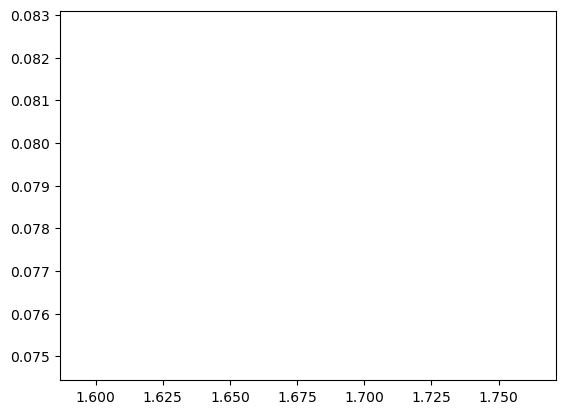

In [139]:
frontier(mu,Q)

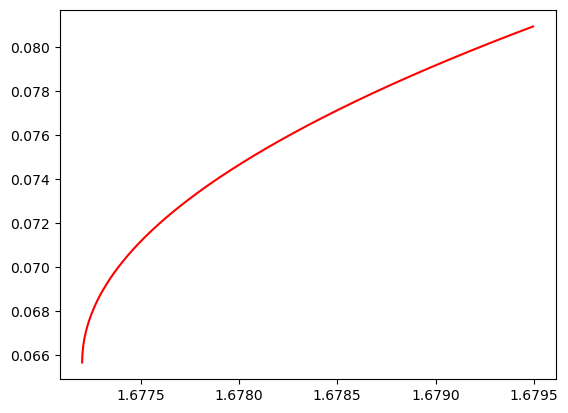

In [140]:
#same as the frontier function just not wrapped since the port function was not working for some reason
#annualized since I was getting some issues with the small return values and slsqp would not work properly

returns = []
std_devs = []

taus = np.arange(0,.5,.001)
for i in range(len(taus)):
        tau= round(taus[i],3)
        sol = port(mu,Q,tau)
        var = sol[0]
        h = sol[1]
        #ret = sol[2]
        #std_dev=sol[3]
        ret = np.asmatrix(mu)*np.asmatrix(h).T
        std_dev = np.sqrt(np.asmatrix(h)*Q*np.asmatrix(h).T)
        returns.append(ret[0,0])
        std_devs.append(std_dev[0,0])
plt.plot(std_devs, returns, color ='red', label = "EFF Frontier")
plt.show()

## Question 4

In [141]:
path_1 = r"C:\Users\bjorn\Downloads\Midtermdata\Midtermdata\data.tsv"

def processdata_1(path): 
    # Folder Path 
    path = path
    #put the data into a dataframe and drop the date column
    df = pd.read_csv(path,sep ="\t")
    df = df.drop(["Unnamed: 0"], axis=1)
    df = df.rename(columns={'AAPL':'^dji','^DJI':'aapl'})
    #make the return data frame
    return_df = df.pct_change(1)
    return_df = return_df.iloc[1:, :]
    
    #drop the dow jones column and make it its own
    index_returns = return_df["^dji"]*252
    return_df = return_df.drop(["^dji"], axis=1)*252
    #make the mu vector and annual mu vector
    annual_mu = return_df.mean()
    
    #annual_mu = mu*252
    
    #dow jones avg return and annual return
    annual_index_mu = index_returns.mean()
    
    #annual_index_mu = index_mu*252
    
    #calculate the index variance, make index returns an array
    index_variance = index_returns.std()**2
    index_returns = index_returns.to_numpy() 
    #convert dataframes into arrays 
    matrix_p = df.to_numpy()
    matrix_r = return_df.to_numpy()
    matrix_r_1 = np.transpose(matrix_r)
    #calculate cov matrix Qts
    Qts = np.cov(matrix_r_1)
    #correlation matrix was used to check
    corr = np.corrcoef(matrix_r_1)
    #return a bunch of variables we may need 
    return df, return_df, annual_mu, annual_index_mu, index_returns, matrix_r, Qts , matrix_r_1, index_variance, #mu

In [142]:
# import the data and generate the variables
x = processdata_1(path_1)

In [143]:
# 5 rows and 5 columns of cov matrix generated
x[6][:5,:5]

array([[17.18975751,  5.16394956,  8.11715676,  7.50404189,  7.76013556],
       [ 5.16394956, 11.80100462,  3.70962075,  5.02306758,  3.46425729],
       [ 8.11715676,  3.70962075, 11.57832659,  5.91223415,  6.43691793],
       [ 7.50404189,  5.02306758,  5.91223415, 15.58659996,  6.22194123],
       [ 7.76013556,  3.46425729,  6.43691793,  6.22194123, 12.60131895]])

In [144]:
#store variables
df, return_df, annual_mu, annual_index_mu, index_returns, matrix_r, Qts , matrix_r_1, index_variance = x

In [145]:
Qts[:5,:5]

array([[17.18975751,  5.16394956,  8.11715676,  7.50404189,  7.76013556],
       [ 5.16394956, 11.80100462,  3.70962075,  5.02306758,  3.46425729],
       [ 8.11715676,  3.70962075, 11.57832659,  5.91223415,  6.43691793],
       [ 7.50404189,  5.02306758,  5.91223415, 15.58659996,  6.22194123],
       [ 7.76013556,  3.46425729,  6.43691793,  6.22194123, 12.60131895]])

In [146]:
#used to look at the covariances a little easier
df_1 = pd.DataFrame(Qts,return_df.columns,return_df.columns)

## Question 5

In [147]:
# regression function to find intercepts, betas, std deviations, and estimate covariance matrix
def regress(index_returns, matrix_r):
    
    #calculate index variance  
    index_var = np.std(index_returns)**2 
    #create arrays to store intercepts, betas, idiosyncratic std devs, variances
    intercepts = []
    betas = []
    idiosyn_std_devs = []
    variances = []
    mus = []
    #loop for each of the 30 stocks
    for i in range( matrix_r.shape[1]):
        #independent variable is the dow jones returns
        X = index_returns
        #dependent variable is the stock returns
        y =  matrix_r[:,i]
        X = X.reshape(-1, 1)
        y = y.reshape(-1, 1)
        #fit the line and get the score, beta, alpha(intercept)
        reg = LinearRegression().fit(X, y)
        s = reg.score(X,y)
        beta = reg.coef_[0][0]
        alpha = reg.intercept_[0]
        #run a prediction and calculate the residual std dev
        residuals = y-reg.predict(X)
        #vol = np.sqrt(np.sum(residuals**2)/(matrix_r.shape[0]-1))
        vol = np.std(residuals)
        
        #add intercepts and estimate the variance with the beta and vol(residual std dev)
        intercepts.append(alpha)
        betas.append(beta)
        idiosyn_std_devs.append(vol)
        #formula for variance given from beta, index variance and volatility
        variance = ((beta**2)*index_var)+vol**2
        variances.append(variance)
        mu = alpha+beta*index_returns.mean()
        mus.append(mu)
    
    #estimate covariance matrix (and correlation matrix to compare) by using the formula provided
    Qsi = np.zeros((matrix_r.shape[1], matrix_r.shape[1]))
    corr_1 = np.zeros((matrix_r.shape[1], matrix_r.shape[1]))
    #put variances on the diagonal and the covariances elsewhere
    for i in range(matrix_r.shape[1]):
        for j in range(matrix_r.shape[1]):
            if i == j :
                Qsi[i,j] = variances[i]
                corr_1[i,j] = 1
            else:
                #formula for covariance given from betas and index variance
                Qsi[i,j]= betas[i]*betas[j]*index_var
                corr_1[i,j]= Qsi[i,j]/(np.sqrt(variances[i])*np.sqrt(variances[j]))
    
    return intercepts, betas, idiosyn_std_devs, index_var, variances,mus, Qsi, corr_1
        

In [148]:
#assign the variables output
intercepts, betas, idiosyn_std_devs, index_var, variances, mus, Qsi, corr_1 = regress(index_returns, matrix_r)
#5 rows and 5 columns of the estimated covariance matrix
Qsi[:5,:5]

array([[17.12072233,  5.45491294,  6.51690302,  6.79705457,  6.77493237],
       [ 5.45491294, 11.75361102,  4.8844674 ,  5.09444308,  5.07786232],
       [ 6.51690302,  4.8844674 , 11.53182729,  6.08625506,  6.06644628],
       [ 6.79705457,  5.09444308,  6.08625506, 15.52400318,  6.32723339],
       [ 6.77493237,  5.07786232,  6.06644628,  6.32723339, 12.55071125]])

In [149]:
Qts[:5,:5]

array([[17.18975751,  5.16394956,  8.11715676,  7.50404189,  7.76013556],
       [ 5.16394956, 11.80100462,  3.70962075,  5.02306758,  3.46425729],
       [ 8.11715676,  3.70962075, 11.57832659,  5.91223415,  6.43691793],
       [ 7.50404189,  5.02306758,  5.91223415, 15.58659996,  6.22194123],
       [ 7.76013556,  3.46425729,  6.43691793,  6.22194123, 12.60131895]])

In [150]:
df_2 = pd.DataFrame(Qsi,return_df.columns,return_df.columns)

## Question 6: Annual mu

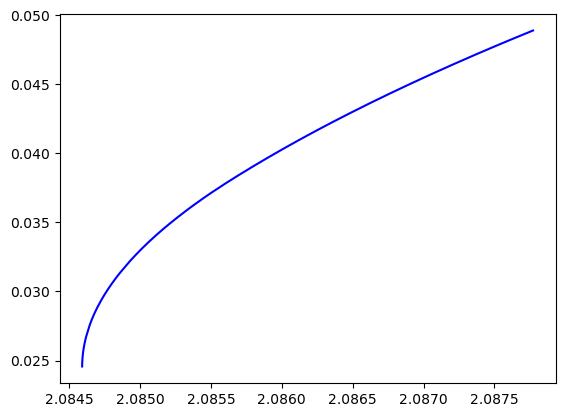

In [151]:
#couldn't call frontier, but this is the frontier for annual mu and the calculated covariance matrix from Q4
returns = []
std_devs = []

taus = np.arange(.001,.5,.001)
for i in range(len(taus)):
        tau= round(taus[i],3)
        sol = port(annual_mu,Qts,tau)
        var = sol[0]
        h = sol[1]
        #ret = sol[2]
        #std_dev=sol[3]
        ret = np.asmatrix(annual_mu)*np.asmatrix(h).T
        std_dev = np.sqrt(np.asmatrix(h)*Qts*np.asmatrix(h).T)
        returns.append(ret[0,0])
        std_devs.append(std_dev[0,0])
plt.plot(std_devs, returns, color ='blue', label = "EFF Frontier")
plt.show()

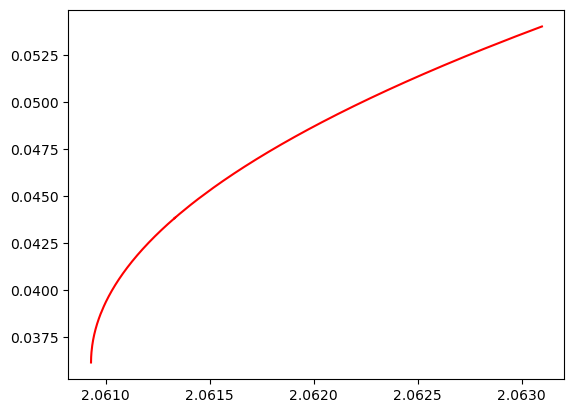

In [152]:
#couldn't call frontier, but this is the frontier for annual mu and the estimated covariance matrix from Q5
returns_1 = []
std_devs_1 = []

taus = np.arange(.001,.5,.001)
for i in range(len(taus)):
        tau= round(taus[i],3)
        sol = port(mus,Qsi,tau)
        var = sol[0]
        h = sol[1]
        #ret = sol[2]
        #std_dev=sol[3]
        ret = np.asmatrix(mus)*np.asmatrix(h).T
        std_dev = np.sqrt(np.asmatrix(h)*Qsi*np.asmatrix(h).T)
        returns_1.append(ret[0,0])
        std_devs_1.append(std_dev[0,0])
plt.plot(std_devs_1, returns_1, color ='red', label = "EFF Frontier")
plt.show()

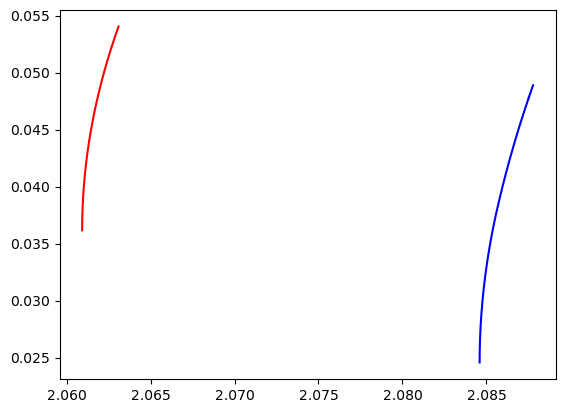

In [153]:
#superimposed plots, they are close with the difference in std deviation being off by a factor of .025
plt.plot(std_devs, returns, color='blue')
plt.plot(std_devs_1, returns_1, color='red')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

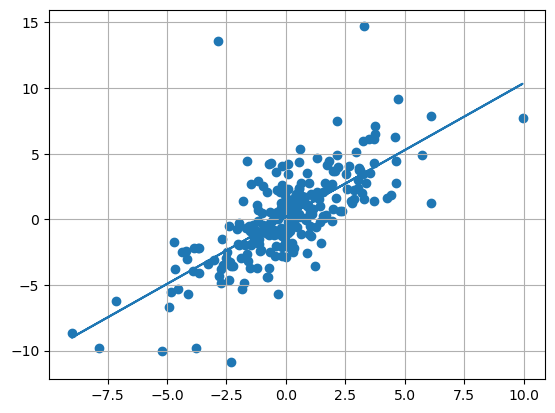

In [154]:
#a look at regression
x= index_returns
x = sm.add_constant(x)
y = matrix_r[:,2]
model = sm.OLS(y, x)
results = model.fit()
predict = results.predict(x)
plt.plot(index_returns,predict)
plt.scatter(index_returns,y)
plt.grid()
plt.show

In [155]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     253.0
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           1.06e-39
Time:                        19:26:55   Log-Likelihood:                -569.93
No. Observations:                 249   AIC:                             1144.
Df Residuals:                     247   BIC:                             1151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1756      0.152      1.156      0.2

In [156]:
df_1.head()

,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,HD,...,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM,aapl
AXP,17.189758,5.163950,8.117157,7.504042,7.760136,5.749718,6.395502,5.803977,6.435895,7.092305,...,6.239094,5.199586,4.521560,4.736512,7.085481,5.935080,6.234735,4.520417,4.878846,5.864956
BA,5.163950,11.801005,3.709621,5.023068,3.464257,4.267319,4.262013,4.100070,5.104498,6.164554,...,4.875137,4.528996,3.842933,4.200445,5.726216,4.608220,6.011435,4.046447,3.509210,3.484391
CAT,8.117157,3.709621,11.578327,5.912234,6.436918,5.088507,5.292388,5.142882,5.860775,6.103578,...,5.771296,4.211307,3.951963,4.873973,5.495761,6.033398,5.452918,4.121900,5.328031,4.738707
CSCO,7.504042,5.023068,5.912234,15.586600,6.221941,10.180008,7.189573,4.093393,8.207462,7.003930,...,4.362807,4.042409,3.797098,4.019818,4.503392,5.831677,5.687167,4.223546,2.880183,8.315665
CVX,7.760136,3.464257,6.436918,6.221941,12.601319,6.605386,6.610962,5.378391,6.416051,6.645179,...,6.029496,5.314021,4.868431,5.123564,5.275225,5.952877,6.353332,4.353866,4.976422,6.271119


In [157]:
df_2.head()

,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,HD,...,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM,aapl
AXP,17.120722,5.454913,6.516903,6.797055,6.774932,7.338864,6.522561,5.861374,6.807852,7.447319,...,6.276218,5.660381,4.897404,5.583335,6.589393,6.244609,7.147881,4.785256,4.953482,6.718693
BA,5.454913,11.753611,4.884467,5.094443,5.077862,5.500533,4.888708,4.393144,5.102536,5.581821,...,4.704072,4.242498,3.670641,4.184751,4.938799,4.680381,5.357390,3.586585,3.712672,5.035710
CAT,6.516903,4.884467,11.531827,6.086255,6.066446,6.571405,5.840467,5.248423,6.095924,6.668518,...,5.619884,5.068449,4.385260,4.999460,5.900309,5.591581,6.400394,4.284840,4.435473,6.016088
CSCO,6.797055,5.094443,6.086255,15.524003,6.327233,6.853899,6.091539,5.474045,6.357978,6.955187,...,5.861475,5.286334,4.573775,5.214379,6.153954,5.831955,6.675537,4.469038,4.626148,6.274710
CVX,6.774932,5.077862,6.066446,6.327233,12.550711,6.831592,6.071713,5.456228,6.337285,6.932551,...,5.842397,5.269129,4.558889,5.197408,6.133925,5.812973,6.653810,4.454493,4.611091,6.254288


<function matplotlib.pyplot.show(close=None, block=None)>

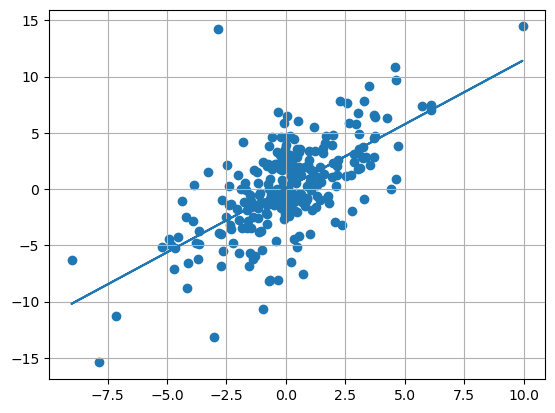

In [158]:
x= index_returns
x = sm.add_constant(x)
y = matrix_r[:,0]
model = sm.OLS(y, x)
results = model.fit()
predict = results.predict(x)
plt.plot(index_returns,predict)
plt.scatter(index_returns,y)
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

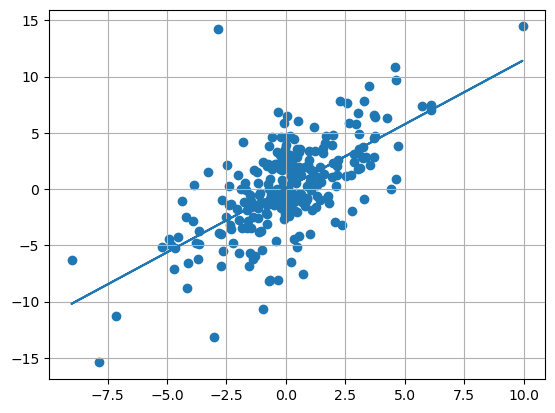

In [159]:
X = index_returns
        #dependent variable is the stock returns
y =  matrix_r[:,0]
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
#fit the line and get the score, beta, alpha(intercept)
reg = LinearRegression().fit(X, y)
s = reg.score(X,y)
beta = reg.coef_[0][0]
alpha = reg.intercept_[0]
predict = reg.predict(X)
#run a prediction and calculate the residual std dev
residuals = y-reg.predict(X)
vol = np.sqrt(np.sum(residuals**2)/(matrix_r.shape[0]-1))
        
plt.plot(index_returns,predict)
plt.scatter(index_returns,y)
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

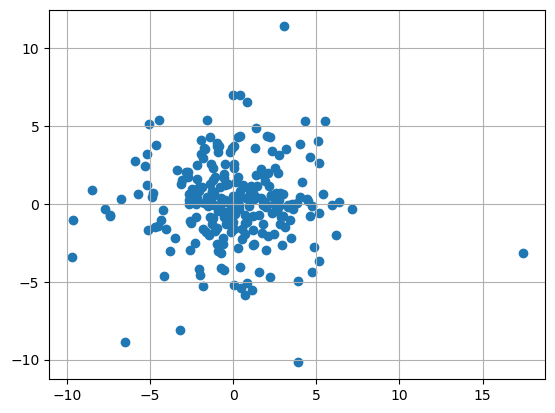

In [160]:
plt.scatter(residuals, predict)
plt.grid()
plt.show

In [161]:
vol


3.143630678583644

In [162]:
np.std(residuals)

3.1373118165593445